# ROZDZIAL 3 - KLASYFIKACJA

## Zbior danych MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, y_train

((60000, 28, 28), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
digt_8 = X_train[3600]

In [6]:
digt_5 = X_train[11]

Text(0.5, 1.0, '8')

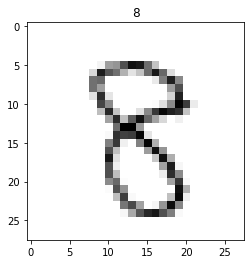

In [7]:
plt.imshow(digt_8, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[3600], fontsize=12)

Text(0.5, 1.0, '5')

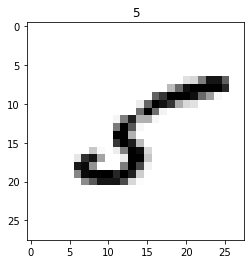

In [8]:
plt.imshow(digt_5, cmap=mpl.cm.binary, interpolation="nearest")
plt.title(y_train[11], fontsize=12)

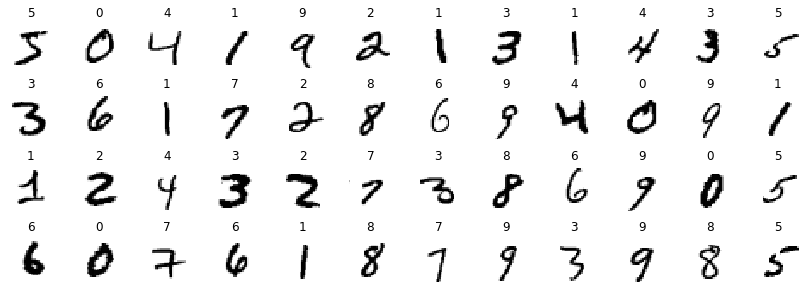

In [9]:
n_rows = 4
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap=mpl.cm.binary, interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(X_train.shape[0])

In [12]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] # przetasowanie indeksów"

In [13]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))

In [14]:
X_train = X_train.reshape((nsamples,nx*ny))

In [15]:
nsamples2, nx2, ny2 = X_test.shape

In [16]:
nsamples2, nx2, ny2

(10000, 28, 28)

In [17]:
X_test = X_test.reshape((nsamples2,nx2*ny2))

## Klasyfiktaor binarny

In [18]:
# klasyfikacja jedynie piatek
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [19]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [20]:
from sklearn.linear_model import SGDClassifier

In [21]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([False])

In [23]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona piatke

array([ True])

## Miary wydajności

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9425 , 0.96635, 0.9536 ])

In [26]:
# Własna implementacja cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [27]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.964
0.95975
0.96265


In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
# XD bo tylko 10% danych to piatki
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90735, 0.9129 , 0.9087 ])

## Macierz pomylek

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import  confusion_matrix

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
y_train_pred

array([False, False, False, ..., False, False,  True])

In [33]:
confusion_matrix(y_train_5, y_train_pred)

array([[53398,  1181],
       [ 1570,  3851]])

In [34]:
# TN  FP
# FN  TP

## Precyzja i Pelnosc

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.765302066772655

In [37]:
recall_score(y_train_5, y_train_pred)

0.7103855377236672

In [38]:
f1_score(y_train_5, y_train_pred)

0.7368219649861284

## Komporomis pomiedzy precyzja a pelnoscia

In [39]:
y_scores = sgd_clf.decision_function([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5
y_scores

array([3860.81606011])

In [40]:
threshold = 2000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([ True])

In [41]:
threshold = 6000
y_digit_5_predic = (y_scores > threshold)
y_digit_5_predic

array([False])

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xlabel("Próg", fontsize=16)

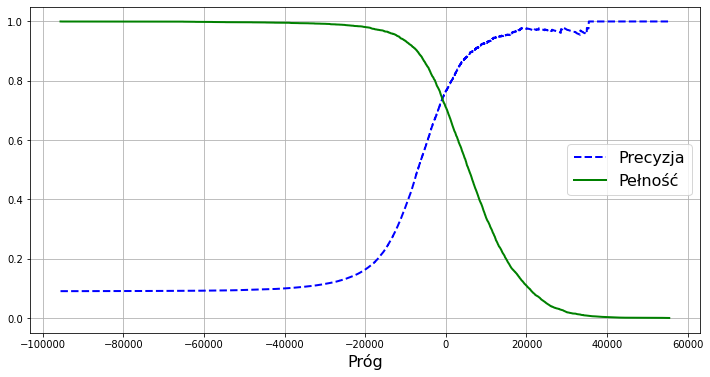

In [46]:
plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

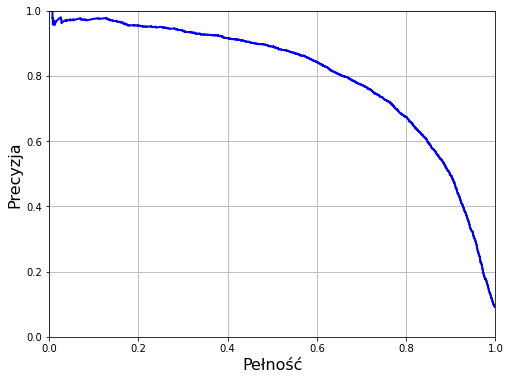

In [48]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## Wykres krzywej ROC

In [49]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [51]:
def plot_roc_curve(fpr, tpr, label=None, color="b"):
    plt.plot(fpr, tpr, color, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)
    plt.grid(True)


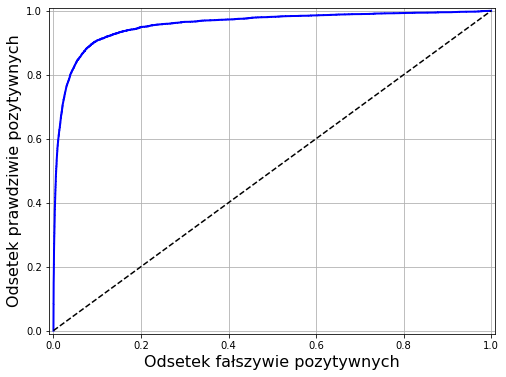

In [52]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## RandomForest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [55]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

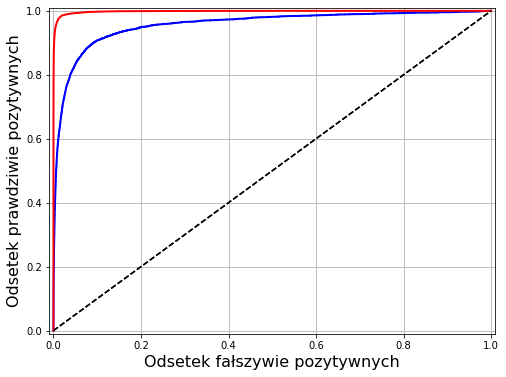

In [56]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr,  "SGD", "b")
plot_roc_curve(fpr_forest, tpr_forest, "Forest", "r")
plt.show()

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_score(y_train_5, y_scores)

0.9568892315632206

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983518506345493

In [60]:
y_train_pred_forest = cross_val_predict(forest_clf, d2_X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9913847446942635

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.8703191293119351

## Klasyfkacja wieloklasowa

In [62]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # klasyfikator stochastycznego spadku wzdluz gradinetu
sgd_clf.fit(X_train, y_train) # klasyfifkatory same dobierają strategie OvA OvO gdy uzywamy klasyfikacji binarnej

SGDClassifier(random_state=42)

In [63]:
sgd_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [64]:
sgd_clf.decision_function([digt_5.reshape((nx*ny,))])

array([[-25640.42555382, -15617.65766126,  -2632.15711493,
        -13888.62806792,  -3375.69225788,    204.65371412,
        -18620.81910291, -21188.328269  ,   2640.38587837,
         -9123.48349151]])

In [65]:
sgd_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([8], dtype=uint8)

In [66]:
digit_8_scores = sgd_clf.decision_function([digt_8.reshape((nx*ny,))])

In [67]:
digit_8_scores

array([[-15797.84832403, -21074.25726441,  -2158.10438851,
         -1103.90200139,  -5712.01892555,  -4482.80176242,
        -15649.06356003, -16399.00648382,   1843.39467852,
         -4679.34153979]])

In [68]:
np.argmax(digit_8_scores)

8

In [69]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [70]:
sgd_clf.classes_[8]

8

## Bezpośrednie strategie OvA OvO

In [71]:
from sklearn.multiclass import OneVsOneClassifier

In [72]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [73]:
ovo_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [74]:
ovo_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [75]:
len(ovo_clf.estimators_) # 10*9/2 tyle kombinacji

45

In [76]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
forest_clf.predict([digt_8.reshape((nx*ny,))]) # przewiduje wyswietlona 8

array([8], dtype=uint8)

In [78]:
forest_clf.predict([digt_5.reshape((nx*ny,))]) # przewiduje wyswietlona 5

array([5], dtype=uint8)

In [79]:
forest_clf.predict_proba([digt_5.reshape((nx*ny,))])

array([[0.  , 0.  , 0.01, 0.  , 0.  , 0.91, 0.01, 0.01, 0.04, 0.02]])

In [80]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86195, 0.8682 , 0.88035])

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
# To nie dziala
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Analiza bledow

In [83]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5701,    0,   38,   21,    3,   37,   26,    1,   63,   33],
       [   3, 6306,  105,   76,    8,   32,    8,    9,  161,   34],
       [  74,   36, 5334,   89,   50,   28,   81,   58,  167,   41],
       [  36,   20,  315, 5119,    9,  224,   10,   27,  187,  184],
       [  37,   17,   55,   28, 4706,   45,   48,   34,  150,  722],
       [  92,   19,   68,  336,   51, 4183,   90,   24,  359,  199],
       [  68,   16,  126,   17,   30,  110, 5425,    6,  108,   12],
       [  26,   13,   93,   61,   46,   22,    5, 5246,   51,  702],
       [  45,   71,  140,  173,   19,  302,   25,   14, 4696,  366],
       [  31,    8,   25,   97,   72,   45,    0,  106,   71, 5494]])

<Figure size 576x432 with 0 Axes>

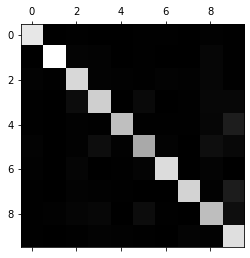

In [84]:
# Rzad to rzeczywiste klasy
# Kolumny to przewidywane
plt.figure(figsize=(8, 6))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums

In [86]:
np.fill_diagonal(norm_conf_mx, 0)

<Figure size 576x432 with 0 Axes>

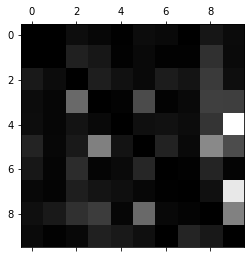

In [87]:
plt.figure(figsize=(8, 6))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Klasyfikacja wieloetykietowa

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [90]:
y_multilabel.shape

(60000, 2)

In [91]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [92]:
knn_clf.predict([digt_5.reshape((nx*ny,))])

array([[False,  True]])

In [93]:
knn_clf.predict([digt_8.reshape((nx*ny,))])

array([[ True, False]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [95]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9771363229522437

## Klasyfikacja wielowyjsciowa

In [96]:
nx*ny

784

In [97]:
noise =np.random.randint(0, 100, X_train.shape)

In [98]:
noise.shape

(60000, 784)

In [99]:
X_train_mod = X_train + noise

In [100]:
noise =np.random.randint(0, 100, X_test.shape)

In [101]:
noise.shape

(10000, 784)

In [102]:
X_test_mod = X_test + noise

In [103]:
digt_1_mod = X_test_mod[342]

In [104]:
digt_1_train = X_test[342]

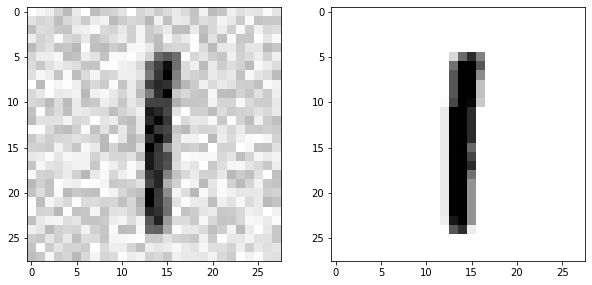

In [105]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(digt_1_mod.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 2, 2)
plt.imshow(digt_1_train.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")

In [106]:
y_train_mod = X_train
y_test_mod = X_test

In [107]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [108]:
clean_digit_1 = knn_clf.predict([X_test_mod[342]])

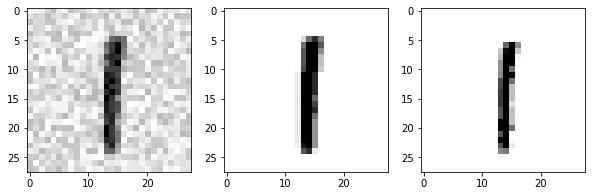

In [109]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(digt_1_mod.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 3, 2)
plt.imshow(digt_1_train.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")
plt.subplot(1, 3, 3)
plt.imshow(clean_digit_1.reshape((nx2,ny2,)), cmap=mpl.cm.binary, interpolation="nearest")

## CWICZENIA

### Zadanie 1


In [124]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [127]:
params = {
    "n_neighbors": [2, 3, 4, 5, 6],
    'weights': ["uniform", "distance"]
}

In [129]:
knn = KNeighborsClassifier(n_jobs=1)
grid = GridSearchCV(knn, params, cv=4, n_jobs=2)

In [130]:
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [117]:
grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'